In [1]:
import os
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.stats import spearmanr, pearsonr
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_squared_error
from consts import DATA_CLEAN_ACTION_PATH_X, DATA_CLEAN_ACTION_PATH_Y, DATA_GAME_REVIEWS_PATH, reaction_time_bins

/anaconda/envs/final_project_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_df = pd.read_csv(DATA_CLEAN_ACTION_PATH_X)
y_df = pd.read_csv(DATA_CLEAN_ACTION_PATH_Y)
X_df['user_id'] = X_df['user_id'].apply(lambda x: 'X_' + str(x))
y_df['user_id'] = y_df['user_id'].apply(lambda x: 'y_' + str(x))
actions_df = pd.concat([X_df, y_df])
labels = range(len(reaction_time_bins) + 1)
bin_edges = [-1] + [b[0] for b in reaction_time_bins] + [reaction_time_bins[-1][1]]
bin_labels = ["-1-0"] + [f"{b[0]}-{b[1]}" if b[1] != np.inf else f"{b[0]}+" for b in reaction_time_bins]

In [3]:
actions_df['reaction_time_bins'] = pd.cut(actions_df['reaction_time'], bins=bin_edges, include_lowest=True)
actions_df['last_reaction_time_bins'] = pd.cut(actions_df['last_reaction_time'], bins=bin_edges, include_lowest=True)
actions_df['last_reaction_time_bins_categories'] = actions_df['last_reaction_time_bins'].apply(lambda x: (x.left))
actions_df['reaction_time_bins_categories'] = actions_df['reaction_time_bins'].apply(lambda x: (x.left))

In [4]:
actions_df[['user_id','strategy_id','gameId','roundNum','hotelId','reviewId','hotelScore','didGo','didWin','correctAnswers','user_points','bot_points', 'last_didWin_True','last_last_didWin_True', 'reaction_time']].head(20)

,user_id,strategy_id,gameId,roundNum,hotelId,reviewId,hotelScore,didGo,didWin,correctAnswers,user_points,bot_points,last_didWin_True,last_last_didWin_True,reaction_time
0,X_0,3,0,1,289,19772,9.071429,False,False,0,0,0,False,False,58821
1,X_0,3,0,2,831,16383,6.442857,True,False,0,0,0,False,False,66297
2,X_0,3,0,3,821,19651,7.828571,False,True,1,0,1,False,False,34276
3,X_0,3,0,4,125,1804,10.000000,True,True,2,1,1,True,False,16300
4,X_0,3,0,5,590,20786,7.157143,False,True,3,2,2,True,True,22520
5,X_0,3,0,6,1049,13842,7.842857,False,True,4,3,2,True,True,12159
6,X_0,3,0,7,229,19516,9.685714,True,True,5,4,2,True,True,19276
7,X_0,3,0,8,843,24184,6.585714,False,True,6,5,3,True,True,23212
8,X_0,3,0,9,432,23375,9.142857,True,True,7,6,3,True,True,25286
9,X_0,3,0,10,729,3479,6.500000,False,True,8,7,4,True,True,5175


In [5]:
actions_df[['reaction_time', 'reaction_time_bins', 'last_reaction_time', 'last_reaction_time_bins']]

,reaction_time,reaction_time_bins,last_reaction_time,last_reaction_time_bins
0,58821,"(20000.0, inf]",-1,"(-1.001, 0.0]"
1,66297,"(20000.0, inf]",58821,"(20000.0, inf]"
2,34276,"(20000.0, inf]",66297,"(20000.0, inf]"
3,16300,"(12000.0, 20000.0]",34276,"(20000.0, inf]"
4,22520,"(20000.0, inf]",16300,"(12000.0, 20000.0]"
...,...,...,...,...
15620,139,"(0.0, 400.0]",135,"(0.0, 400.0]"
15621,136,"(0.0, 400.0]",139,"(0.0, 400.0]"
15622,133,"(0.0, 400.0]",136,"(0.0, 400.0]"
15623,141,"(0.0, 400.0]",133,"(0.0, 400.0]"


- review length- DONE
- positive/negative proportion- DONE
- review quality? 
- player strategy 
- last creation time - DONE
- number of mistakes in the current game - DONE
- % mistakes in the current game - DONE
- total mistakes % so far - DONE
- did mistake in the last round - DONE
- did mistake in the last last round - DONE

* all to continous and binning representations

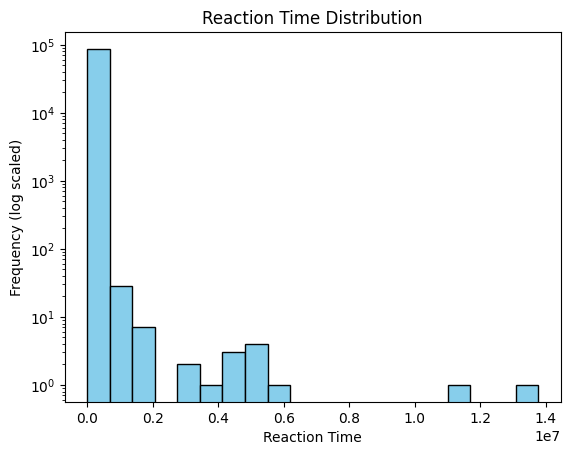

In [9]:
fig, ax = plt.subplots()
ax.hist(actions_df['reaction_time'], bins=20, color='skyblue', edgecolor='black', log=True)
ax.set_xlabel('Reaction Time')
ax.set_ylabel('Frequency (log scaled)')
ax.set_title('Reaction Time Distribution')
plt.show()

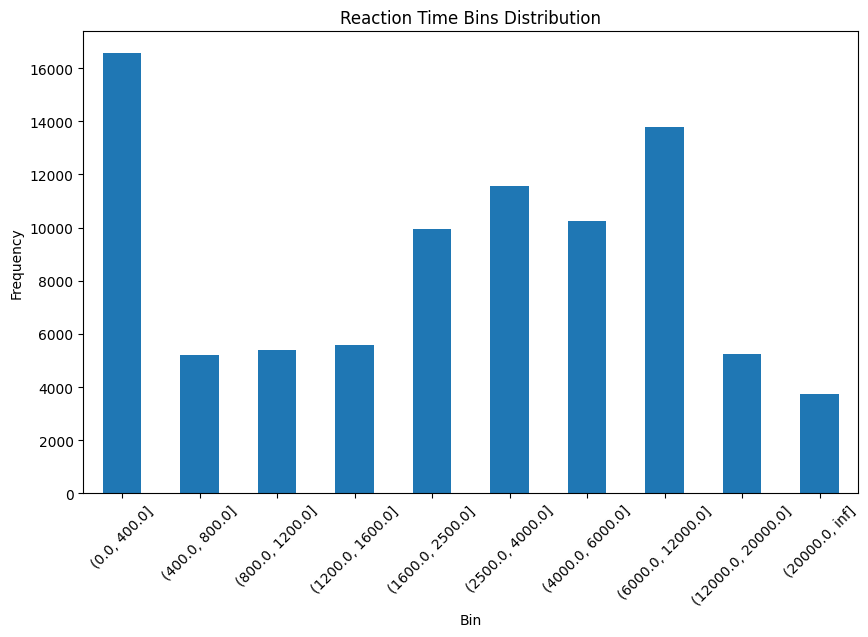

In [16]:
plt.figure(figsize=(10, 6))
bins_count = actions_df['reaction_time_bins'].value_counts()
bins_count = bins_count[bins_count > 0]
bins_count.sort_index().plot(kind='bar')
plt.xlabel('Bin')
plt.ylabel('Frequency')
plt.title('Reaction Time Bins Distribution')
plt.xticks(rotation=45)
plt.show()

### Feature Extraction

In [4]:
hotel_dfs = dict()
with open("data/baseline_proba2go.txt", 'r') as file:
    probs_dict = json.load(file)
def load_hotel_df(hotel_id):
    if hotel_id not in hotel_dfs:
        hotel_dfs[hotel_id] = pd.read_csv(os.path.join(DATA_GAME_REVIEWS_PATH, f'{hotel_id}.csv'), names=['reviewId', 'hotelId', 'positive', 'negative', 'score'])
    return hotel_dfs[hotel_id]

def get_review(row):
    hotel_id = row['hotelId']
    review_id = row['reviewId']
    hotel_df = load_hotel_df(hotel_id)
    review_row = hotel_df.loc[hotel_df['reviewId'] == review_id]
    positive_review = review_row['positive'].iloc[0]
    negative_review = review_row['negative'].iloc[0]
    return pd.Series([positive_review, negative_review])

def add_review_prob(row):
    review_id = row['reviewId']
    return probs_dict[str(review_id)]

In [5]:
def add_mistakes_columns(df):
    # Calculate the cumulative sum of mistakes, then shift within each group so the calculation will be correct to the start of the round
    df['mistakes_cumulative'] = df.groupby(['user_id', 'gameId'])['didWin'].transform(lambda x: (~x).cumsum())  
    df['current_game_mistakes_amount'] = df.groupby(['user_id', 'gameId'])['mistakes_cumulative'].shift(fill_value=0)  
    
    # Calculate cumulative mistakes across all games for each user, then shift  
    df['total_mistakes_cumulative'] = df.groupby(['user_id'])['didWin'].transform(lambda x: (~x).cumsum())  
    df['total_games_mistakes_amount'] = df.groupby(['user_id'])['total_mistakes_cumulative'].shift(fill_value=0)  
    
    # For percentage calculations, adjust for the shift by avoiding division by zero  
    df['rounds_so_far'] = df.groupby(['user_id', 'gameId']).cumcount()  
    df['total_rounds_so_far'] = df.groupby(['user_id']).cumcount() 
    df['current_game_mistakes_percentage'] = df['current_game_mistakes_amount'] / df['rounds_so_far'].replace(0, pd.NA)  
    df['total_games_mistakes_percentage'] = df['total_games_mistakes_amount'] / df['total_rounds_so_far'].replace(0, pd.NA)  
    
    # Fill NaN values in the percentage columns  
    df.fillna({'current_game_mistakes_percentage': 0, 'total_games_mistakes_percentage': 0}, inplace=True)  
    df.drop(['mistakes_cumulative', 'total_mistakes_cumulative', 'rounds_so_far', 'total_rounds_so_far'], axis=1, inplace=True)
    return df

In [6]:
actions_df[['positive_review', 'negative_review']] = actions_df.apply(get_review, axis=1)
actions_df['positive_review'] = actions_df['positive_review'].fillna('')
actions_df['negative_review'] = actions_df['negative_review'].fillna('')
actions_df['review_length'] = actions_df['positive_review'].str.len() + actions_df['negative_review'].str.len()
actions_df['positive_review_proportion'] = actions_df.apply(lambda row: len(row['positive_review']) / row['review_length'] if row['review_length'] != 0 else 0, axis=1)
actions_df = add_mistakes_columns(actions_df)
actions_df['user_earned_more'] = actions_df['user_points'] >= actions_df['bot_points']
actions_df['bot_earned_more'] = actions_df['user_points'] < actions_df['bot_points']
actions_df['review_prob'] = actions_df.apply(add_review_prob, axis=1)

In [8]:
actions_df[['user_id','strategy_id', 'gameId','roundNum', 'current_game_mistakes_amount', 'current_game_mistakes_percentage', 'total_games_mistakes_percentage', 'total_games_mistakes_amount', 'last_didWin_True','last_last_didWin_True']].head(20)

,user_id,strategy_id,gameId,roundNum,current_game_mistakes_amount,current_game_mistakes_percentage,total_games_mistakes_percentage,total_games_mistakes_amount,last_didWin_True,last_last_didWin_True
0,X_0,3,0,1,0,0.000000,0.000000,0,False,False
1,X_0,3,0,2,1,1.000000,1.000000,1,False,False
2,X_0,3,0,3,2,1.000000,1.000000,2,False,False
3,X_0,3,0,4,2,0.666667,0.666667,2,True,False
4,X_0,3,0,5,2,0.500000,0.500000,2,True,True
5,X_0,3,0,6,2,0.400000,0.400000,2,True,True
6,X_0,3,0,7,2,0.333333,0.333333,2,True,True
7,X_0,3,0,8,2,0.285714,0.285714,2,True,True
8,X_0,3,0,9,2,0.250000,0.250000,2,True,True
9,X_0,3,0,10,2,0.222222,0.222222,2,True,True


In [129]:
actions_df[['reviewId', 'hotelId', 'positive_review', 'negative_review', 'review_length','positive_review_proportion', 'review_prob']].head(5)

,reviewId,hotelId,positive_review,negative_review,review_length,positive_review_proportion,review_prob
0,19772,289,"The hotel was spotless, the staff extremely he...",,302,1.000000,0.999982
1,16383,831,silence..,"Not only did not like, I HATE it.. Today I had...",650,0.013846,0.000000
2,19651,821,,"The staircase was extremely steep, with a very...",148,0.000000,0.011723
3,1804,125,"The hotel was immaculately clean, quiet, and c...",,416,1.000000,0.999940
4,20786,590,Close to the station and centrally located. In...,Unfortunately too noisy for me. The rooms and ...,326,0.263804,0.014334


In [7]:
all_features = ['gameId', 'roundNum', 'user_points', 'bot_points', 'last_didGo_True', 'last_last_didGo_True', 'last_didWin_True', 'last_last_didWin_True',
                'current_game_mistakes_amount', 'current_game_mistakes_percentage', 'total_games_mistakes_percentage', 'total_games_mistakes_amount', 'review_length',
                'positive_review_proportion', 'last_reaction_time', 'user_earned_more', 'bot_earned_more', 'last_reaction_time_bins_categories', 'review_prob']

label_column = 'reaction_time'
categorial_label_column = 'reaction_time_bins_categories'

### Correlations to 'reaction_time' continous representation

In [10]:
def plot_correlation(df, x_col, y_col, remove_outliers=False):
    if remove_outliers:
        non_outliers_df = df[df['reaction_time'] < 0.7*1e7]
        x = non_outliers_df[x_col]
        y = non_outliers_df[y_col]
    else:
        x = df[x_col]
        y = df[y_col]
    fig, ax = plt.subplots()
    coefficients = np.polyfit(x, y, 1)
    polynomial = np.poly1d(coefficients)
    x_values = np.linspace(min(x), max(x), 100)
    y_values = polynomial(x_values)
    ax.plot(x_values, y_values, color='red', label='Regression Line')
    spearman_corr, p_value = spearmanr(x, y)
    spearman_corr = round(spearman_corr,2)
    p_value = round(p_value,2)
    ax.scatter(x, y, label='Data Points')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f'Regression Plot of {x_col} vs {y_col}\nSpearman Test: Statistic: {spearman_corr}, P-value: {p_value}')
    ax.legend()
    plt.show()
    return fig, ax

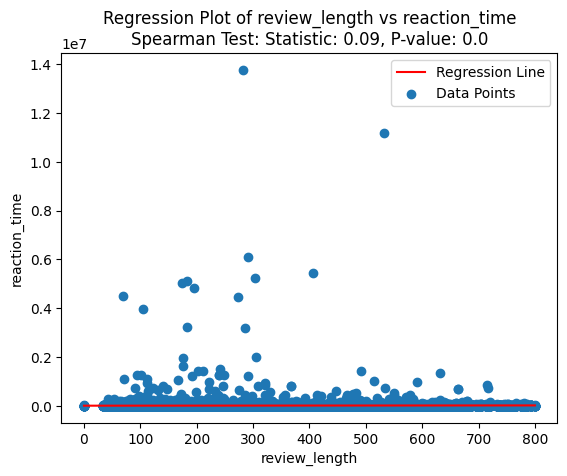

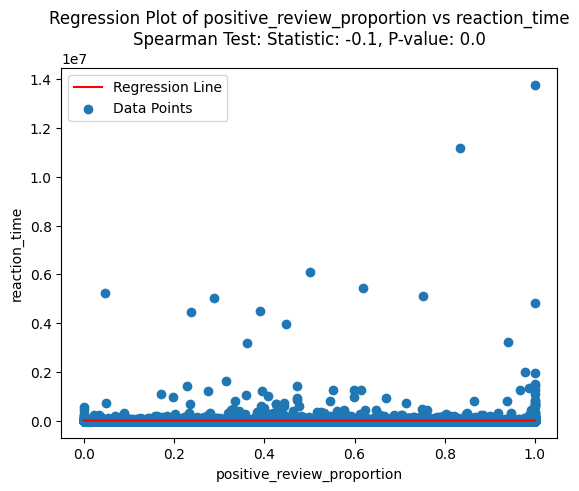

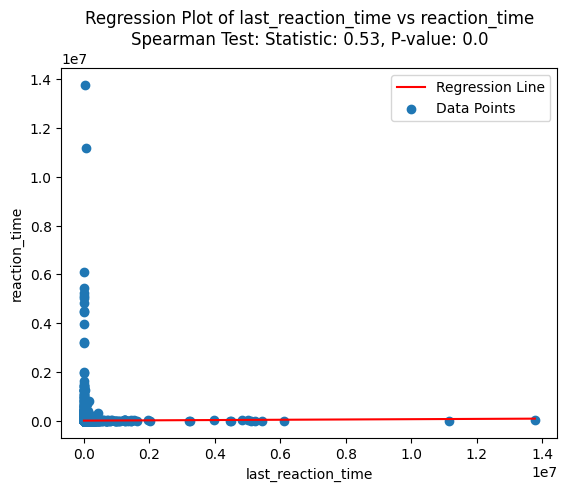

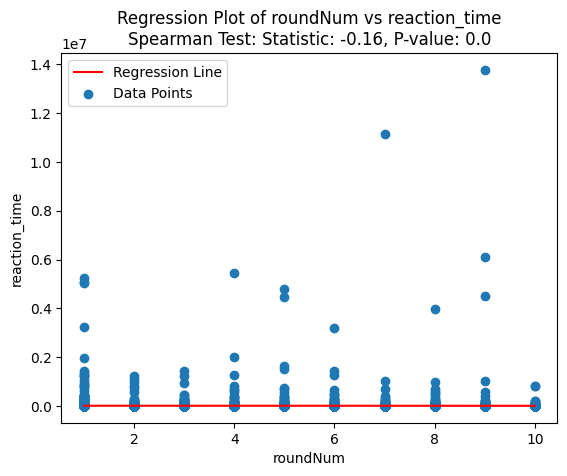

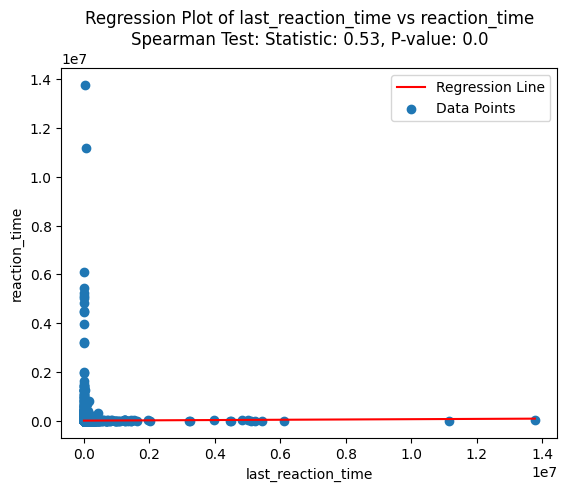

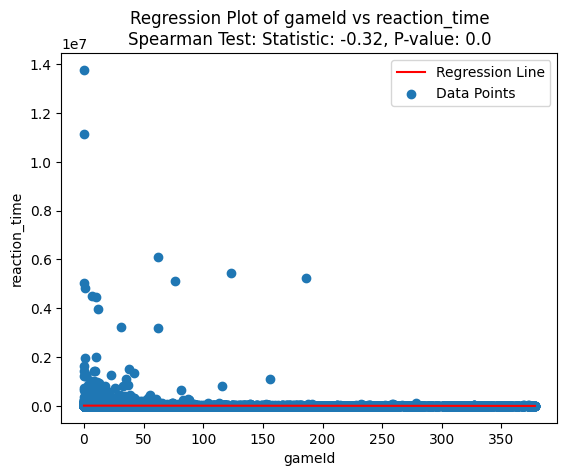

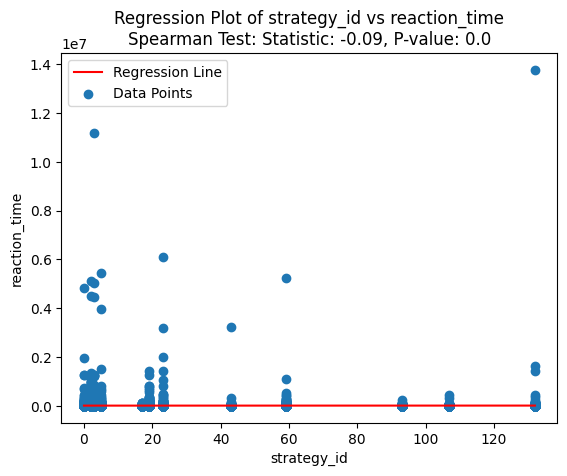

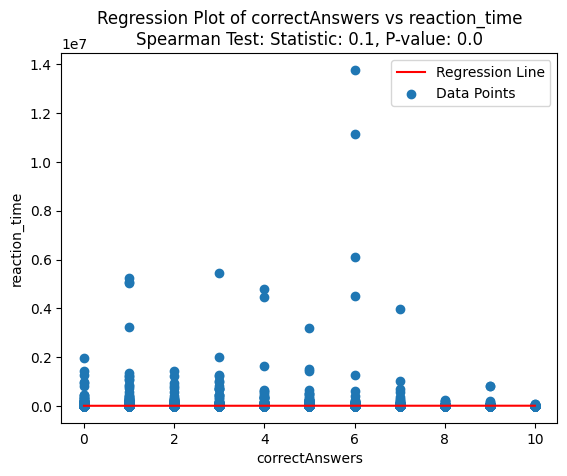

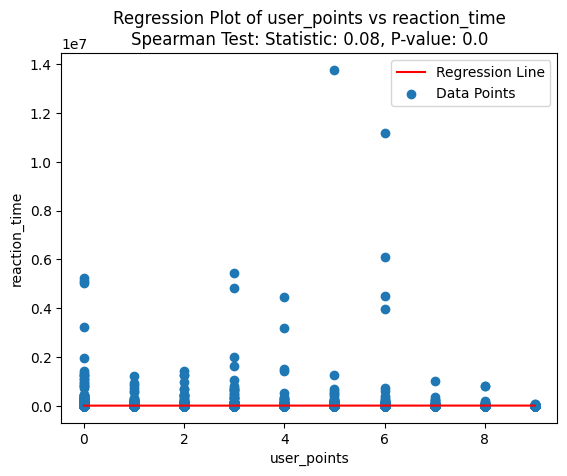

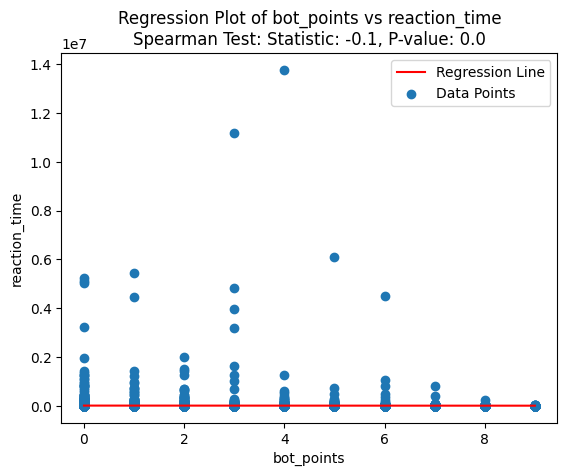

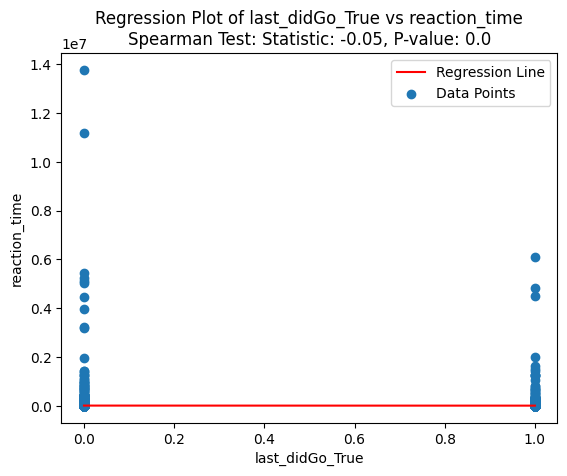

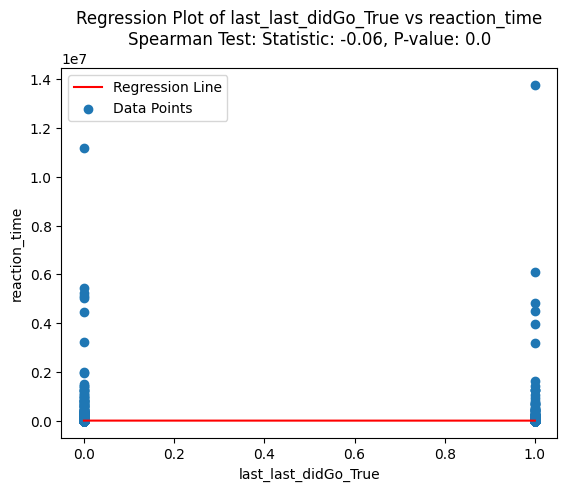

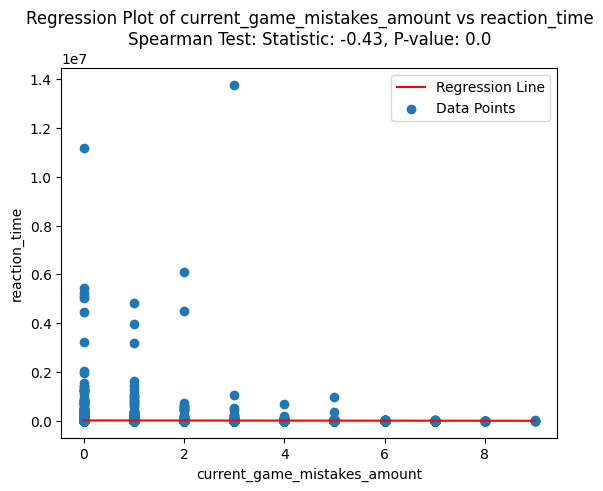

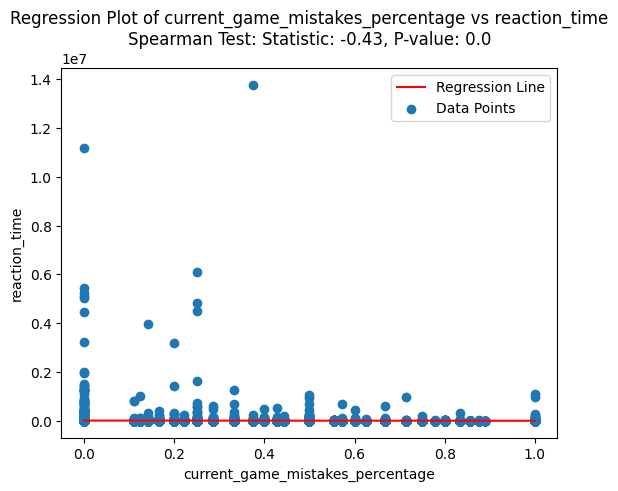

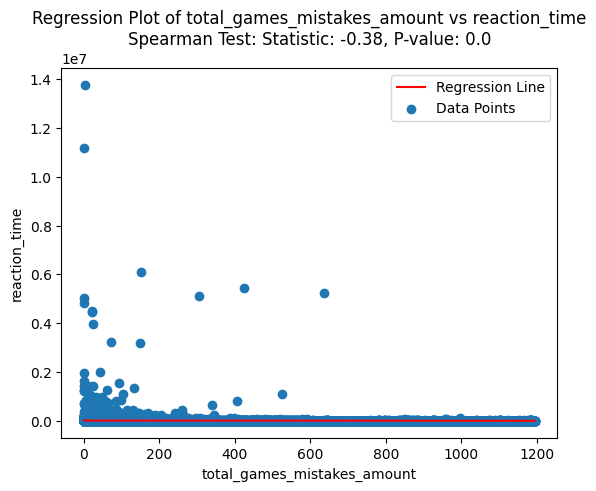

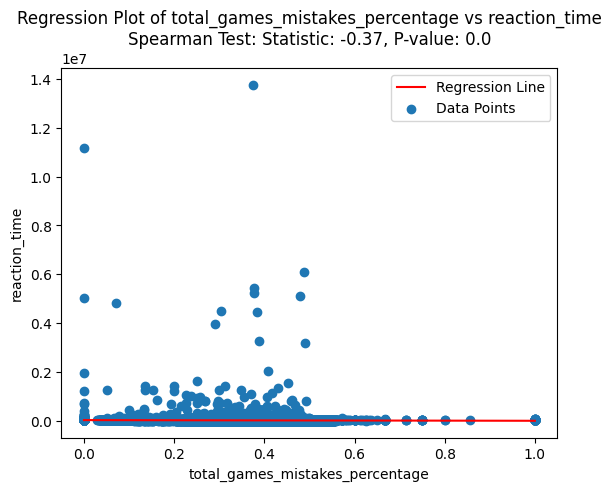

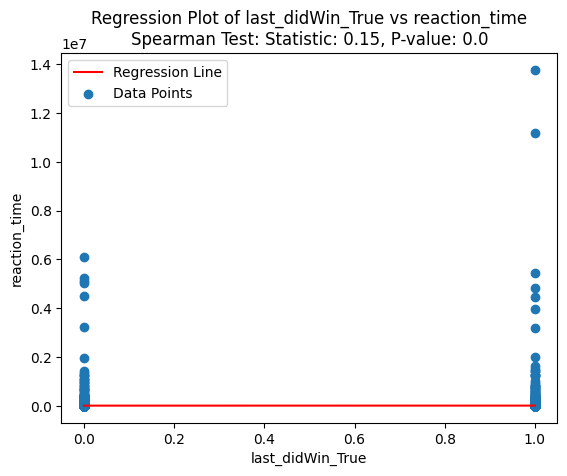

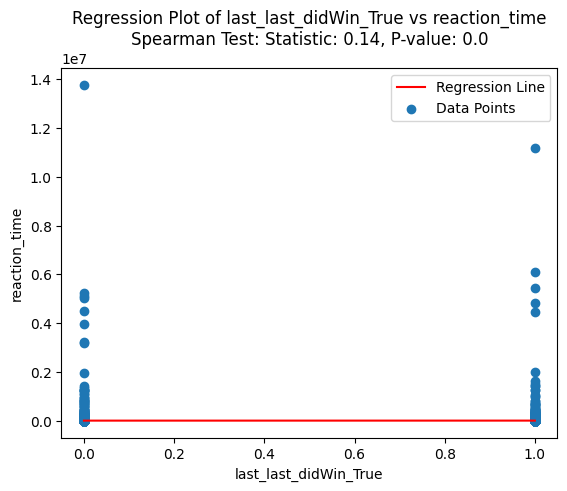

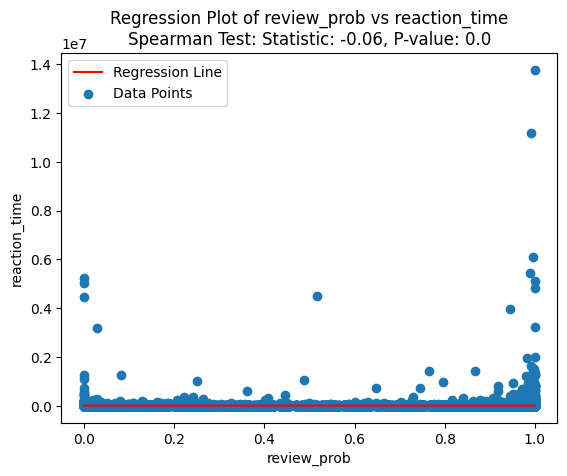

In [131]:
_,_ = plot_correlation(actions_df, 'review_length', 'reaction_time')
_,_ = plot_correlation(actions_df, 'positive_review_proportion', 'reaction_time')
_,_ = plot_correlation(actions_df, 'last_reaction_time', 'reaction_time')
_,_ = plot_correlation(actions_df, 'roundNum', 'reaction_time')
_,_ = plot_correlation(actions_df, 'last_reaction_time', 'reaction_time')
_,_ = plot_correlation(actions_df, 'gameId', 'reaction_time')
_,_ = plot_correlation(actions_df, 'strategy_id', 'reaction_time')
_,_ = plot_correlation(actions_df, 'correctAnswers', 'reaction_time')
_,_ = plot_correlation(actions_df, 'user_points', 'reaction_time')
_,_ = plot_correlation(actions_df, 'bot_points', 'reaction_time')
_,_ = plot_correlation(actions_df, 'last_didGo_True', 'reaction_time')
_,_ = plot_correlation(actions_df, 'last_last_didGo_True', 'reaction_time')
_,_ = plot_correlation(actions_df, 'current_game_mistakes_amount', 'reaction_time')
_,_ = plot_correlation(actions_df, 'current_game_mistakes_percentage', 'reaction_time')
_,_ = plot_correlation(actions_df, 'total_games_mistakes_amount', 'reaction_time')
_,_ = plot_correlation(actions_df, 'total_games_mistakes_percentage', 'reaction_time')
_,_ = plot_correlation(actions_df, 'last_didWin_True', 'reaction_time')
_,_ = plot_correlation(actions_df, 'last_last_didWin_True', 'reaction_time')
_,_ = plot_correlation(actions_df, 'review_prob', 'reaction_time')


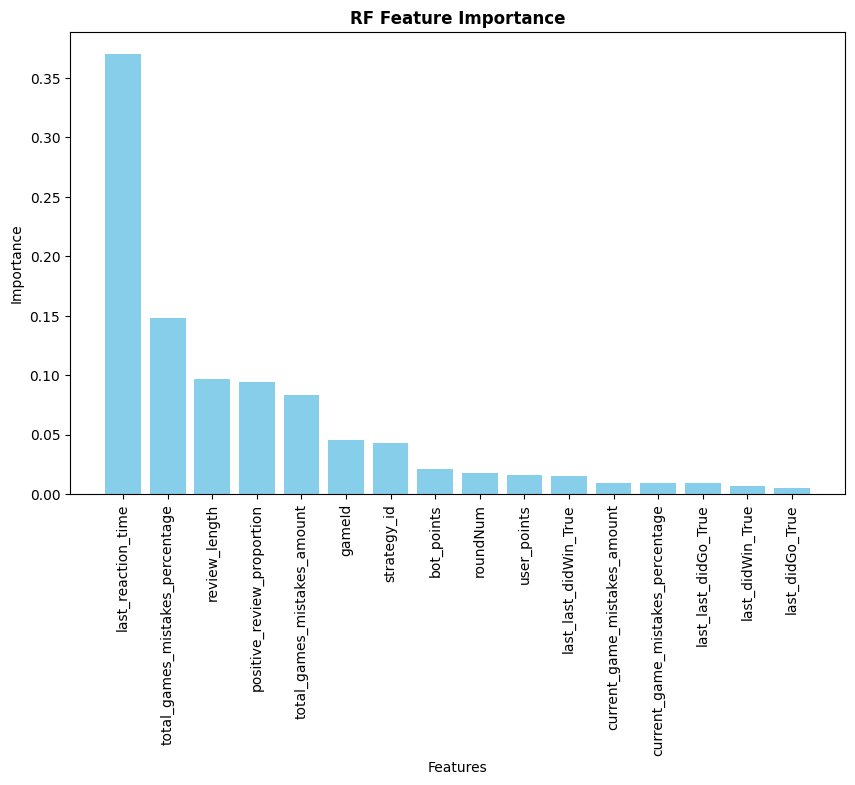

In [30]:
model = RandomForestRegressor()
model.fit(actions_df[all_features], actions_df[label_column])

importances_df = pd.DataFrame({"feature_names": all_features, "importances": model.feature_importances_})
importances_df = importances_df.sort_values(by='importances', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(importances_df["feature_names"], importances_df["importances"], color='skyblue')
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.title("RF Feature Importance", fontweight="bold")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.grid(False)
plt.show()

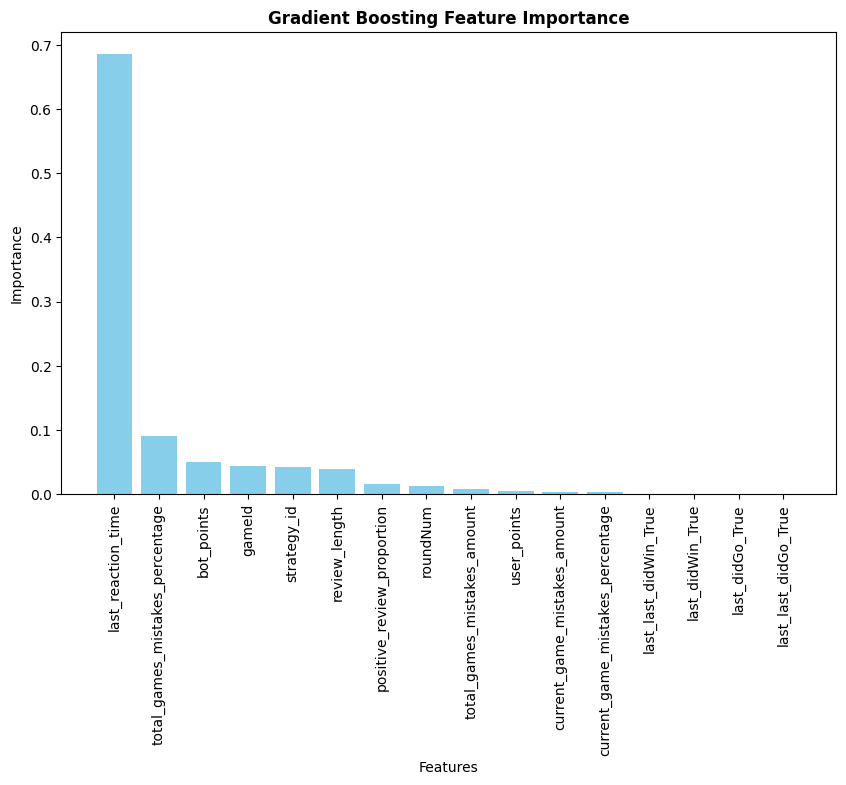

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(actions_df[all_features], actions_df[label_column])

importances_df = pd.DataFrame({"feature_names": all_features, "importances": model.feature_importances_})
importances_df = importances_df.sort_values(by='importances', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(importances_df["feature_names"], importances_df["importances"], color='skyblue')
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.title("Gradient Boosting Feature Importance", fontweight="bold")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.grid(False)
plt.show()

In [8]:
train_df = actions_df[actions_df['user_id'].str.contains('X')]
test_df = actions_df[actions_df['user_id'].str.contains('y')]
X_train, y_train =  train_df[all_features], train_df[label_column]
X_test, y_test = test_df[all_features], test_df[label_column]

In [9]:
selected_features = ['gameId', 'roundNum', 'current_game_mistakes_amount', 'total_games_mistakes_percentage', 'review_length',
                    'positive_review_proportion', 'last_reaction_time', 'user_earned_more', 'bot_earned_more',
                    'last_didGo_True', 'last_didWin_True']

In [117]:
model = RandomForestRegressor(min_samples_leaf=50, max_depth=100)
model.fit(X_train[selected_features], y_train)
y_pred = model.predict(X_test[selected_features])
rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
print(rmse)

360.0431899514701


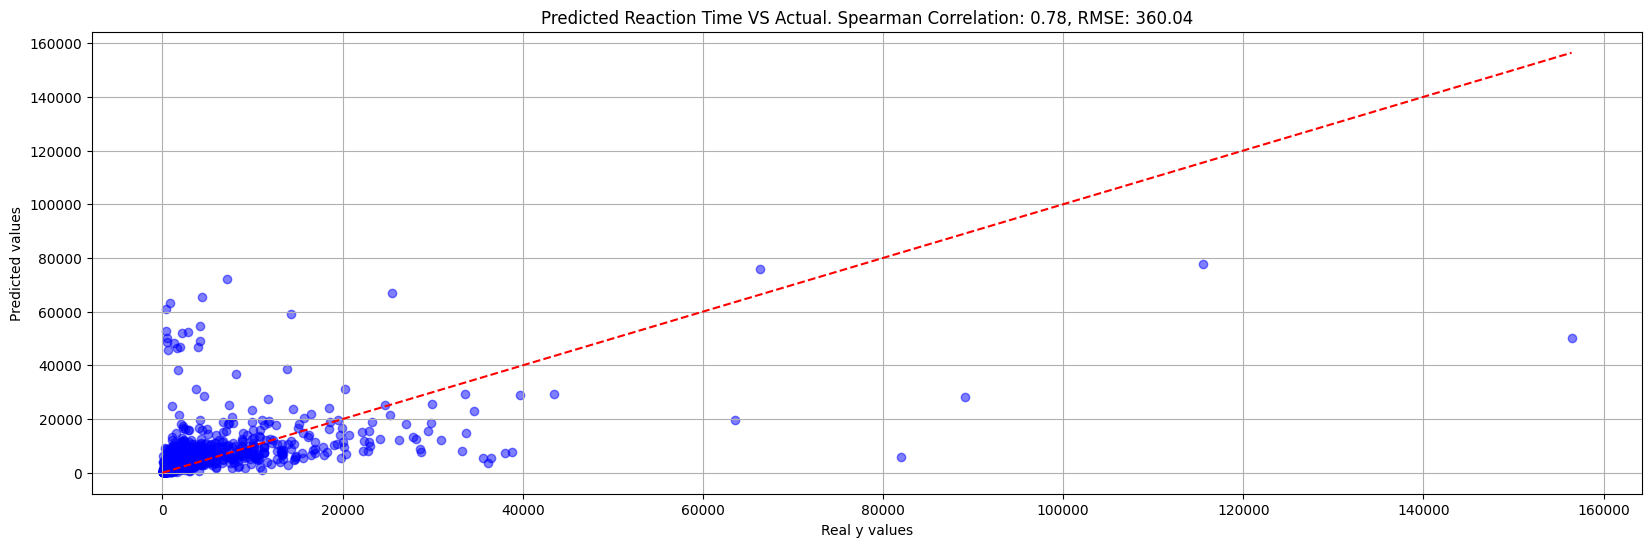

In [118]:
naive_model_rmse = np.sqrt(mean_squared_error(y_test, np.full(len(y_test), y_train.mean()), squared=False))
spearman = spearmanr(y_test, y_pred)[0]
plt.figure(figsize=(20, 6))
np.random.seed(100)
random_indices = np.random.choice(len(y_test), size=1000, replace=False)
sorted_indices = np.argsort(y_test.iloc[random_indices])
sorted_y_test = y_test.iloc[random_indices].iloc[sorted_indices]
sorted_y_pred = y_pred[random_indices][sorted_indices]
# sorted_indices = np.argsort(y_test)
# sorted_y_test = y_test.iloc[sorted_indices]
# sorted_y_pred = y_pred[sorted_indices]

plt.scatter(sorted_y_test, sorted_y_pred, color='blue', alpha=0.5)

# Plot diagonal line
max_val = max(sorted_y_test.max(), sorted_y_pred.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')

# Set plot title with RMSE
plt.title(f"Predicted Reaction Time VS Actual. Spearman Correlation: {spearman:.2f}, RMSE: {rmse:.2f}")
plt.xlabel("Real y values")
plt.ylabel("Predicted values")
plt.grid(True)
plt.show()

In [119]:
naive_model_rmse

360.14691663580936

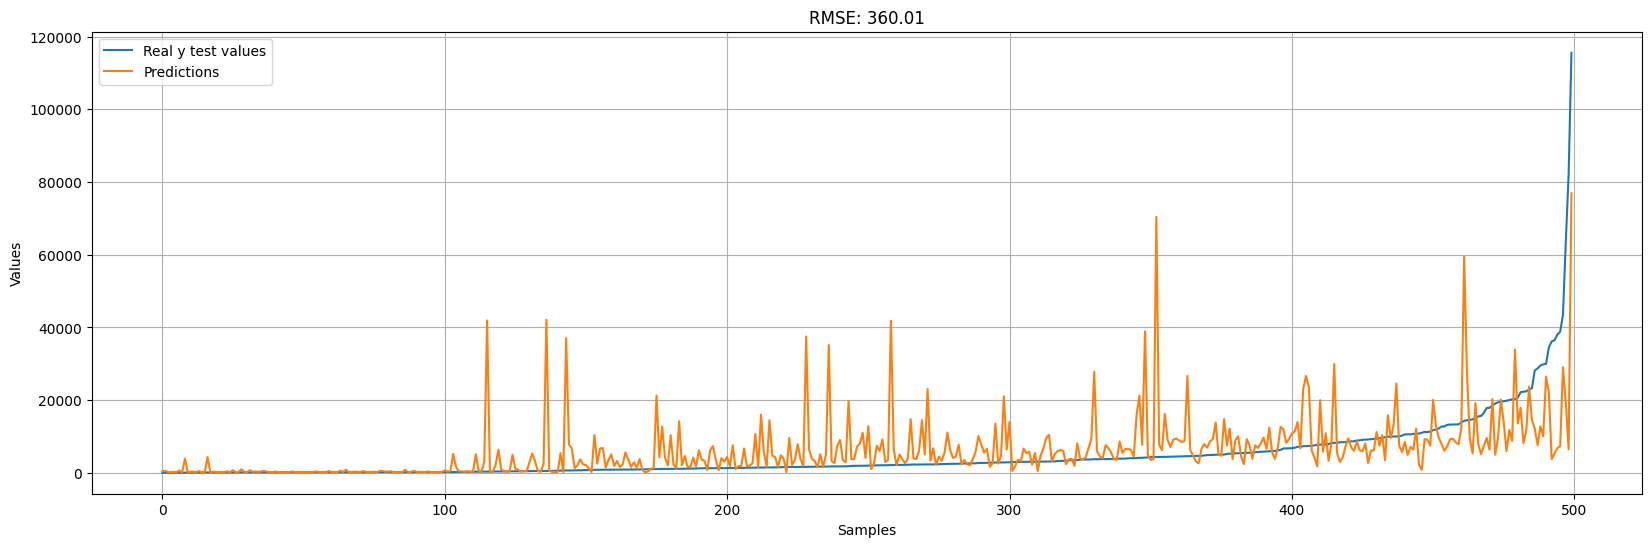

In [33]:
plt.figure(figsize=(20, 6))
np.random.seed(100)
random_indices = np.random.choice(len(y_test), size=500, replace=False)
sorted_indices = np.argsort(y_test.iloc[random_indices])
sorted_y_test = y_test.iloc[random_indices].iloc[sorted_indices]
sorted_y_pred = y_pred[random_indices][sorted_indices]
# Plot real y test values and predictions
plt.plot(sorted_y_test.reset_index(drop=True), label='Real y test values')
plt.plot(sorted_y_pred, label='Predictions')

# Set plot title with RMSE
plt.title(f"RMSE: {rmse:.2f}")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
y_test_binned = pd.cut(y_test, bins=bin_edges, labels=labels, include_lowest=True)
y_pred_binned = pd.cut(y_pred, bins=bin_edges, labels=labels, include_lowest=True)

# Calculate accuracy
accuracy = accuracy_score(y_test_binned, y_pred_binned)
print("Accuracy:", accuracy)

# Calculate F1 score (use average='weighted' to handle class imbalance)
f1 = f1_score(y_test_binned, y_pred_binned, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_binned, y_pred_binned)
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels[1:], columns=bin_labels[1:])
print("Confusion Matrix:")
display(conf_matrix_df)

Accuracy: 0.354432
F1 Score: 0.3591930010490847
Confusion Matrix:


,0-400,400-800,800-1200,1200-1600,1600-2500,2500-4000,4000-6000,6000-12000,12000-20000,20000+
0-400,3134,646,187,123,109,94,60,78,10,37
400-800,145,135,110,83,90,99,81,81,12,51
800-1200,32,46,34,93,169,199,152,144,26,36
1200-1600,18,24,21,50,164,281,261,233,40,38
1600-2500,17,21,29,52,152,433,454,529,101,67
2500-4000,0,9,7,21,98,364,548,575,96,53
4000-6000,0,2,2,6,38,191,375,587,123,73
6000-12000,0,0,4,5,21,114,375,955,265,107
12000-20000,0,1,0,1,1,28,92,336,171,94
20000+,0,0,1,1,2,18,46,204,166,168


### Correlations to 'reaction_time' bins representation

In [26]:
classification_selected_features = ['gameId', 'roundNum', 'current_game_mistakes_amount', 'current_game_mistakes_percentage', 'total_games_mistakes_percentage', 'review_length',
                                     'positive_review_proportion', 'last_reaction_time_bins_categories', 'user_earned_more', 'bot_earned_more',
                                     'last_didGo_True', 'last_didWin_True', 'review_prob']
X_train, y_train =  train_df[classification_selected_features], train_df[categorial_label_column]
X_test, y_test = test_df[classification_selected_features], test_df[categorial_label_column]

In [76]:
# min_samples_leaf=50, 
model = RandomForestClassifier(n_estimators=10, min_samples_leaf=20, class_weight="balanced_subsample")
model.fit(X_train[classification_selected_features], y_train)
y_pred = model.predict(X_test[classification_selected_features])

In [77]:
num_estimators = len(model.estimators_)
print(f"Number of estimators: {num_estimators}")

# Depth of each tree
tree_depths = [estimator.tree_.max_depth for estimator in model.estimators_]
print(f"Depth of each tree: {tree_depths}")

# If you want to find the average depth
average_depth = sum(tree_depths) / num_estimators
print(f"Average depth of trees: {average_depth}")

Number of estimators: 10
Depth of each tree: [28, 20, 22, 23, 24, 21, 21, 23, 21, 22]
Average depth of trees: 22.5


In [78]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels[1:], columns=bin_labels[1:])
print("Confusion Matrix:")
display(conf_matrix_df)

Accuracy: 0.400448
F1 Score: 0.40624156173734716
Confusion Matrix:


,0-400,400-800,800-1200,1200-1600,1600-2500,2500-4000,4000-6000,6000-12000,12000-20000,20000+
0-400,3689,522,152,45,24,24,6,4,2,10
400-800,179,394,170,69,30,14,13,5,4,9
800-1200,49,215,286,167,83,37,25,18,29,22
1200-1600,29,154,269,263,139,80,48,66,53,29
1600-2500,25,236,332,309,249,195,188,102,128,91
2500-4000,9,163,229,222,212,261,252,168,144,111
4000-6000,3,114,115,102,125,188,251,206,163,130
6000-12000,6,121,79,90,108,171,285,395,368,223
12000-20000,4,46,25,33,31,37,64,109,214,161
20000+,3,52,17,18,22,18,37,60,124,255


In [75]:
import pickle
with open('models/rf_basic_classification_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [47]:
train_mode = y_train.value_counts().idxmax()
naive_mode_predictions = np.full(len(y_test), train_mode)
accuracy = accuracy_score(y_test, naive_mode_predictions)
print("Accuracy:", accuracy)

f1 = f1_score(y_test, naive_mode_predictions, average='weighted')
print("F1 Score:", f1)

Accuracy: 0.286592
F1 Score: 0.12767835407650602
